In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import folium
from folium.plugins import HeatMap
from branca.colormap import LinearColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

<h2>1. Загрузка даннных</h2>

In [3]:
df = pd.read_csv('./data.csv')
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [4]:
# общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


Датасет содержит следующие признаки:
- date - дата публикации объявления;
- time - время, когда объявление было опубликовано;
- geo_lat - широта
- geo_lon - долгота
- region - регион России
- building_type - тип фасада. 0 - Другое. 1 - Панельный. 2 - Монолитный. 3 - Кирпичный. 4 - Блочный. 5 - Деревянный
- object_type - тип квартиры. 1 - Вторичный рынок недвижимости; 11 - Новостройка;
- level - этажность квартиры, количество этажей
- rooms - количество жилых комнат. Если значение равно "-1", то это означает "квартира-студия
- area площадь - общая площадь квартиры.
- kitchen_area - площадь кухни
- price - цена квартиры

<h2>2. Очистка и обработка данных</h2>

Проверка на пропуски в данных

In [5]:
df.isna().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

Преобразуем столбец с датами в формат datetime для более удобной работы

In [6]:
df["date"] = df["date"].astype("datetime64[ns]")

Рассмотрим различные статистики признаков для выявления ошибок и аномалий в данных

In [7]:
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06
mean,4.422029e+06,5.403826e+01,5.324433e+01,4.307141e+03,1.948966e+00,6.214530e+00,1.139892e+01,1.726173e+00,5.391825e+01,1.062840e+01,3.945399e+00
std,2.150752e+07,4.622758e+00,2.074763e+01,3.308050e+03,1.038537e+00,4.957419e+00,6.535734e+00,1.082133e+00,3.335293e+01,9.792380e+00,4.558357e+00
min,-2.144967e+09,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,1.000000e+00
25%,1.950000e+06,5.337768e+01,3.777790e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,2.990000e+06,5.517139e+01,4.306774e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.700000e+00,1.000000e+00
75%,4.802000e+06,5.622613e+01,6.564895e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.313000e+01,1.270000e+01,1.100000e+01
max,2.147484e+09,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,1.000000e+01,7.856000e+03,9.999000e+03,1.100000e+01


Как можно заметить в данных присутсвуют некоторые ошибки и выбросы:
- отрицательные цены
- количество комант, равных -2 (минимально возможно -1 у студий)
- слишком маленькая площадь (меньше 1 кв.м)

Произведем очистку датасета

In [8]:
# убираем отрицательные/слишком большие цены
price_lower_percentile = df['price'].quantile(0.01)
price_upper_percentile = df['price'].quantile(0.99)
df = df[(df['price'] >= price_lower_percentile) & (df['price'] <= price_upper_percentile)]

# количество комнат для студий делаей 0
df['rooms'] = df.rooms.apply(lambda x: 0 if x < 0 else x)

# фильтруем по площади
area_lower_percentile = df['area'].quantile(0.01)
area_upper_percentile = df['area'].quantile(0.99)
df = df[(df['area'] >= area_lower_percentile) & (df['area'] <= area_upper_percentile)]

# фильтруем по площади кухни
kitchen_area_lower_percentile = df['kitchen_area'].quantile(0.01)
kitchen_area_upper_percentile = df['kitchen_area'].quantile(0.99)
df = df[(df['kitchen_area'] >= kitchen_area_lower_percentile) & (df['kitchen_area'] <= kitchen_area_upper_percentile)]

Регионы в датасете предаставлены в виде кода. Сопоставим коду региона его название.

In [9]:
region_name = {                     
    2661: 'Санкт-Петербург',
    3446: 'Ленинградская область', 
    3: 'Москва',
    81: 'Московская область',
    2843: 'Краснодарский край',
    2871: 'Нижегородская область',
    3230: 'Ростовская область',
    3106: 'Самарская область',
    2922: 'Республика Татарстан',
    2900: 'Ставропольский край',
    2722: 'Республика Башкортостан',
    6171: 'Свердловская область', 
    4417: 'Республика Коми', 
    5282: 'Челябинская область', 
    5368: 'Иркутская область', 
    5520: 'Пермский край', 
    6817: 'Алтайский край',
    9579: 'Республика Бурятия',
    2604: 'Ярославская область',
    1010: 'Удмуртская Республика',
    7793: 'Псковская область',
    13919: 'Республика Северная Осетия — Алания',
    2860: 'Кемеровская область',
    3019: 'Чувашская Республика',
    4982: 'Республика Марий Эл',
    9648: 'Кабардино-Балкарская Республика',
    5241: 'Республика Мордовия',
    3870: 'Красноярский край',
    3991: 'Тюменская область',
    2359: 'Республика Хакасия',
    9654: 'Новосибирская область',
    2072: 'Воронежская область',
    8090: 'Республика Карелия',
    4007: 'Республика Дагестан',
    11171: 'Республика Саха (Якутия)',
    10160: 'Забайкальский край',
    7873: 'Республика Крым',
    6937: 'Республика Крым',
    2594: 'Кировская область',
    8509: 'Республика Калмыкия',
    11416: 'Республика Адыгея',
    11991: 'Карачаево-Черкесская Республика',
    5178: 'Республика Тыва',
    13913: 'Республика Ингушетия',
    6309: 'Республика Алтай',
    5952: 'Белгородская область',
    6543: 'Архангельская область',
    2880: 'Тверская область',
    5993: 'Пензенская область',
    2484: 'Ханты-Мансийский автономный округ',
    4240: 'Липецкая область',
    5789: 'Владимирская область',
    14880: 'Ямало-Ненецкий автономный округ',
    1491: 'Рязанская область',
    2885: 'Чеченская Республика',
    5794: 'Смоленская область',
    2528: 'Саратовская область',
    4374: 'Вологодская область',
    4695: 'Волгоградская область',
    2328: 'Калужская область',
    5143: 'Тульская область',
    2806: 'Тамбовская область',
    14368: 'Мурманская область',
    5736: 'Новгородская область',
    7121: 'Курская область',
    4086: 'Хабаровский край',
    821: 'Брянская область',
    10582: 'Астраханская область',
    7896: 'Калининградская область',
    8640: 'Омская область',
    5703: 'Курганская область',
    10201: 'Томская область',
    4249: 'Ульяновская область',
    3153: 'Оренбургская область',
    4189: 'Костромская область',
    2814: 'Орловская область',
    13098: 'Камчатский край',
    8894: 'Ивановская область',
    7929: 'Амурская область',
    16705: 'Магаданская область',
    69: 'Еврейская автономная область',
    4963: 'Приморский край',
    1901: 'Сахалинская область',
    61888: 'Ненецкий автономный округ'
}

In [10]:
df['region_name'] = df['region'].map(region_name)
df.region_name

0                Санкт-Петербург
1             Московская область
2          Нижегородская область
3             Краснодарский край
4             Московская область
                   ...          
5477001                   Москва
5477002                   Москва
5477003    Нижегородская область
5477004                   Москва
5477005                   Москва
Name: region_name, Length: 5167246, dtype: object

Сделаем проверку на наличие дубликатов

In [11]:
df.duplicated().sum()

1465

Удалим дубликаты

In [12]:
df = df[df.duplicated() == False]
df.duplicated().sum()

0

<h2>3. Разведочный анализ данных </h2>

Рассмотрим географическое расположение недвижимости

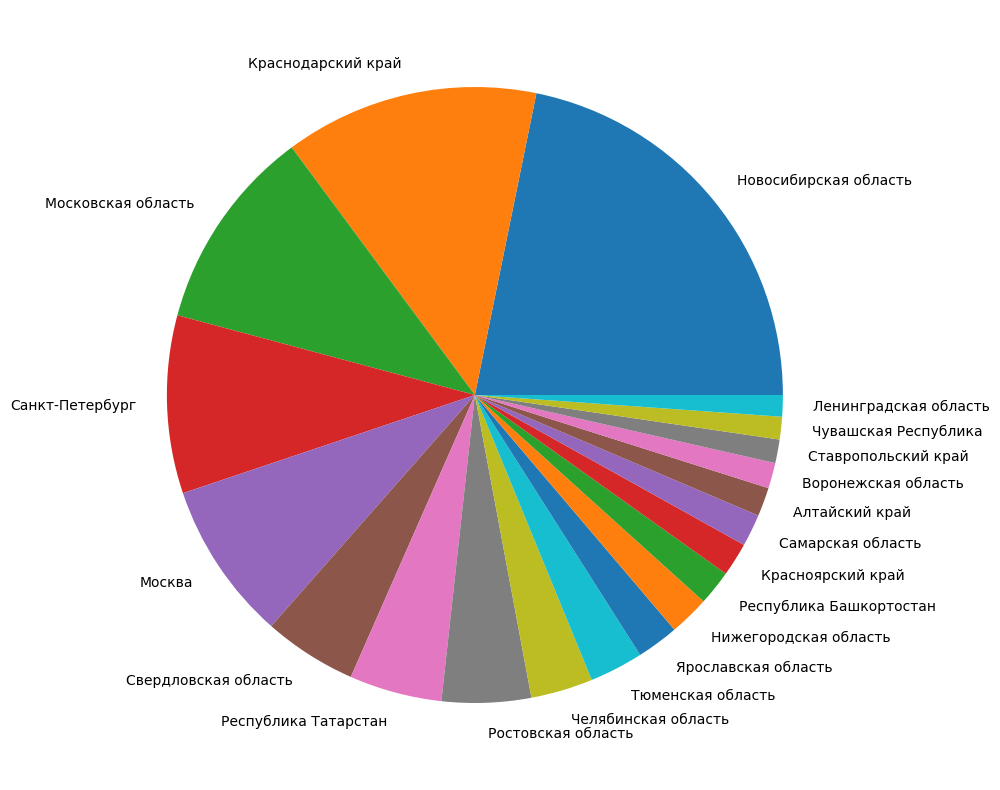

In [14]:
region_freq = df['region_name'].value_counts().head(20)

plt.figure(figsize=(15, 10))
plt.pie(x=region_freq.values, labels=region_freq.index)
plt.show()

Как можно заметить, большинство объявлений находятся в Новосибирской, Краснодарской и Москвоских областях

Также стоит исследовать временные зависимости в данном датасете. Вначале отобразим количество объявлений о продаже в зависимости от месяца

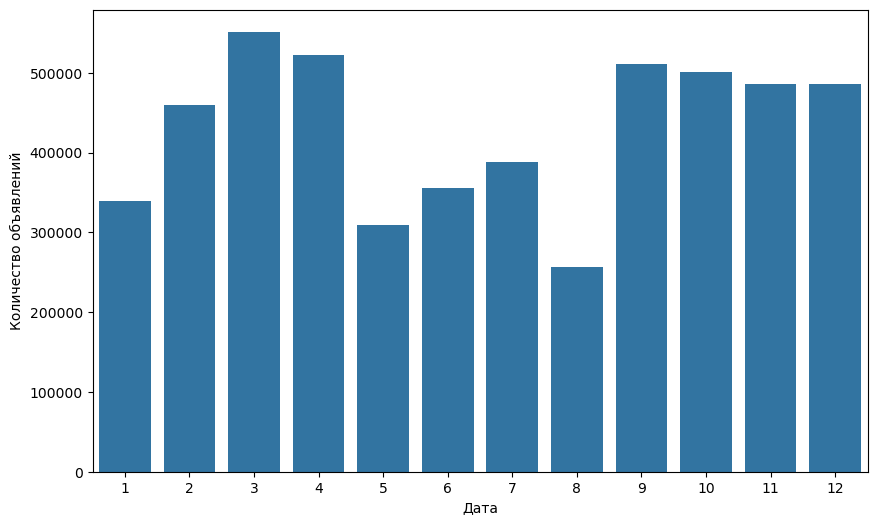

In [15]:
months_cnt = df.date.dt.month.value_counts()

plt.figure(figsize=(10, 6))
#ax = sns.barplot(x=months_cnt.index, y=months_cnt.values)
ax = sns.barplot(x=months_cnt.index, y=months_cnt, color='C0')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество объявлений')
plt.show()

Можно заметить, что в период с апреля по август количество объявлений ниже, чем в остальные месяца.

Далее построим временной ряд количества объявлений на всем времненном промежутке. В качестве шага возмьем месяц.

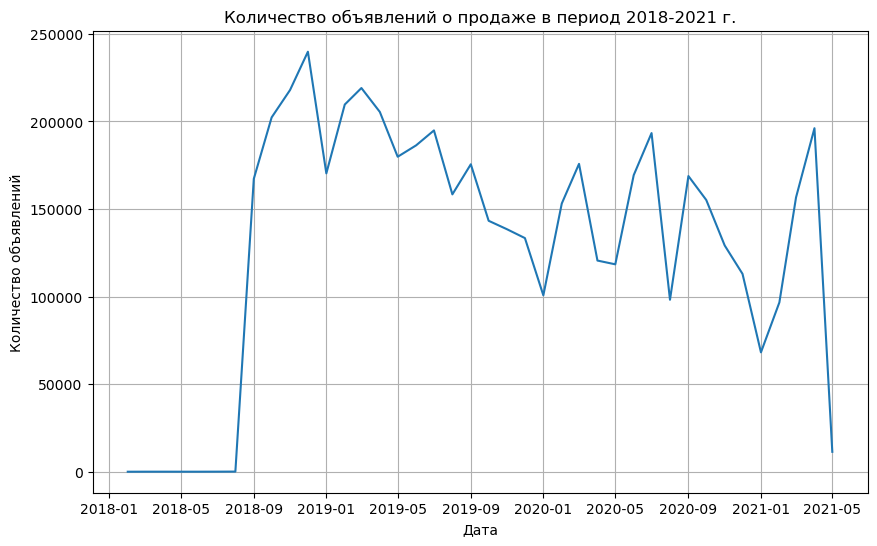

In [16]:
dates = pd.concat([df.date.dt.year, df.date.dt.month], axis=1)
dates.columns = ['year', 'month']
year_month_cnt = dates.groupby(['year', 'month']).size()
date_interval = np.arange(np.datetime64("2018-02"), np.datetime64("2021-06"), np.timedelta64(1, "M"))

plt.figure(figsize=(10, 6))
plt.plot(date_interval, year_month_cnt.values)
plt.xlabel('Дата')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений о продаже в период 2018-2021 г.')
plt.grid(True)
plt.show()

Далее исследуем другие признаки датасета

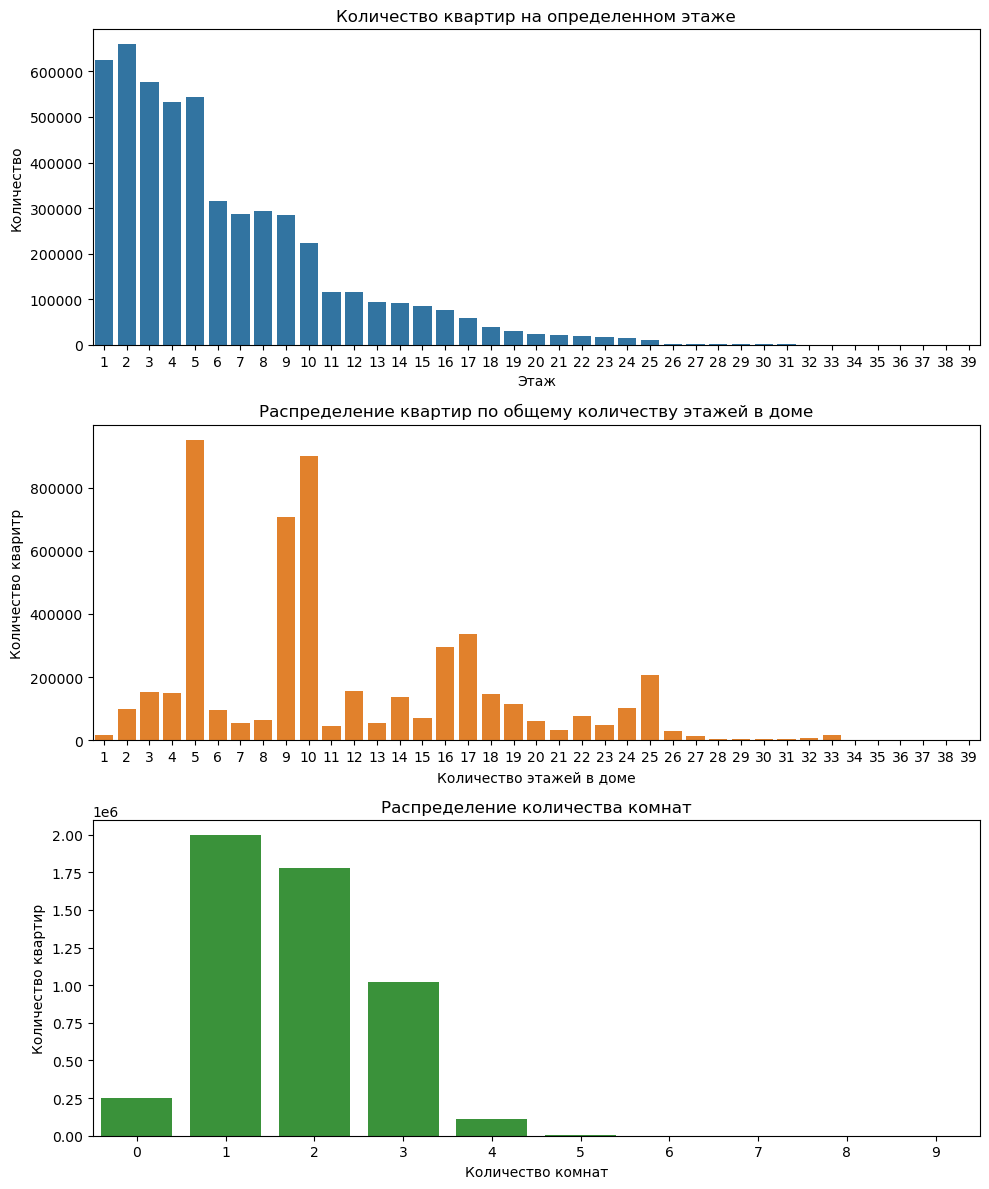

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

level_cnt = df.level.value_counts()
sns.barplot(x=level_cnt.index, y=level_cnt, ax=ax[0], color='C0')
ax[0].set_xlabel('Этаж')
ax[0].set_ylabel('Количество')
ax[0].set_title('Количество квартир на определенном этаже')

levels_cnt = df.levels.value_counts()
sns.barplot(x=levels_cnt.index, y=levels_cnt, ax=ax[1], color='C1')
ax[1].set_xlabel('Количество этажей в доме')
ax[1].set_ylabel('Количество кваритр')
ax[1].set_title('Распределение квартир по общему количеству этажей в доме')

rooms_cnt = df.rooms.value_counts()
sns.barplot(x=rooms_cnt.index, y=rooms_cnt, ax=ax[2], color='C2')
ax[2].set_xlabel('Количество комнат')
ax[2].set_ylabel('Количество квартир')
ax[2].set_title('Распределение количества комнат')

plt.tight_layout()
plt.show()

Из построенных графиков можно сделать несколько наблюдений:
- Большинство квартир находятся на 1-5 этажах
- Больше всего 5-ти и 10-ти этажных домов
- Наиболее частое количество комнат в квартире - 1 или 2

Далее рассмотрим признаками площадь и площадь кухни.

In [18]:
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,region_name
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,Санкт-Петербург
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,Московская область
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,Нижегородская область
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,Краснодарский край
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,Московская область


In [19]:
df.kitchen_area.max()

28.0

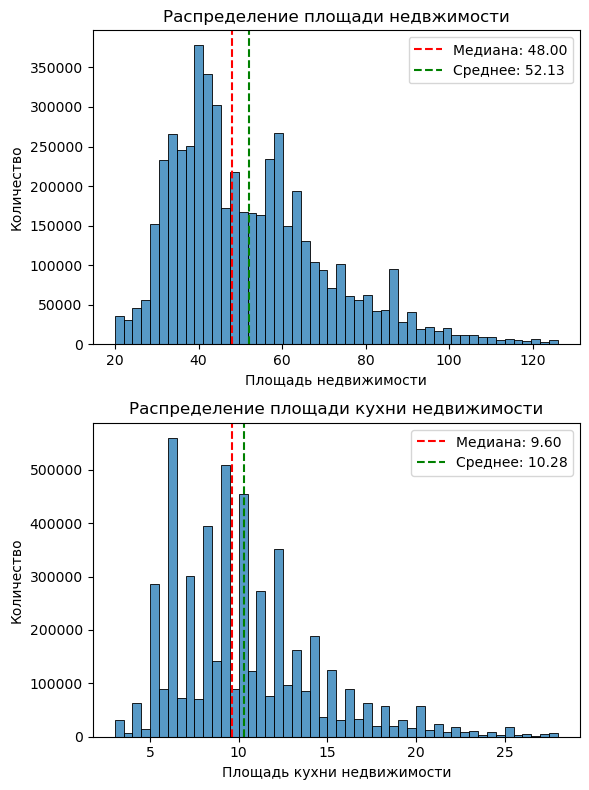

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(df.area, bins=50, ax=ax[0])
ax[0].axvline(df.area.median(), color='red', linestyle='--', label=f'Медиана: {df.area.median():.2f}')
ax[0].axvline(df.area.mean(), color='green', linestyle='--', label=f'Среднее: {df.area.mean():.2f}')
ax[0].set_xlabel('Площадь недвижимости')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение площади недвжимости')
ax[0].legend()

sns.histplot(df.kitchen_area, bins=50, ax=ax[1])
ax[1].axvline(df.kitchen_area.median(), color='red', linestyle='--', label=f'Медиана: {df.kitchen_area.median():.2f}')
ax[1].axvline(df.kitchen_area.mean(), color='green', linestyle='--', label=f'Среднее: {df.kitchen_area.mean():.2f}')
ax[1].set_xlabel('Площадь кухни недвижимости')
ax[1].set_ylabel('Количество')
ax[1].set_title('Распределение площади кухни недвижимости')
ax[1].legend()

plt.tight_layout()
plt.show()

Можно заметить, что среднее значение площади недвижимости равняется 48 м^2, а кухни - 9.6 м^2

Далее рассмотрим последний признак - тип объекта.

In [21]:
df.object_type.value_counts()

1     3630038
11    1535743
Name: object_type, dtype: int64

1 - вторичное жилье, 11 - новое. Можно заметить, что на рынке преобладают объявления о продаже вторичной недвижимости.

In [22]:
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,region_name
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,Санкт-Петербург
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,Московская область
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,Нижегородская область
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,Краснодарский край
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,Московская область


Главная задача данной работы - предсказать цену недвижимости. Для этого более подробно исследуем данную величину.

Вначале посмотрим на ее распределение.

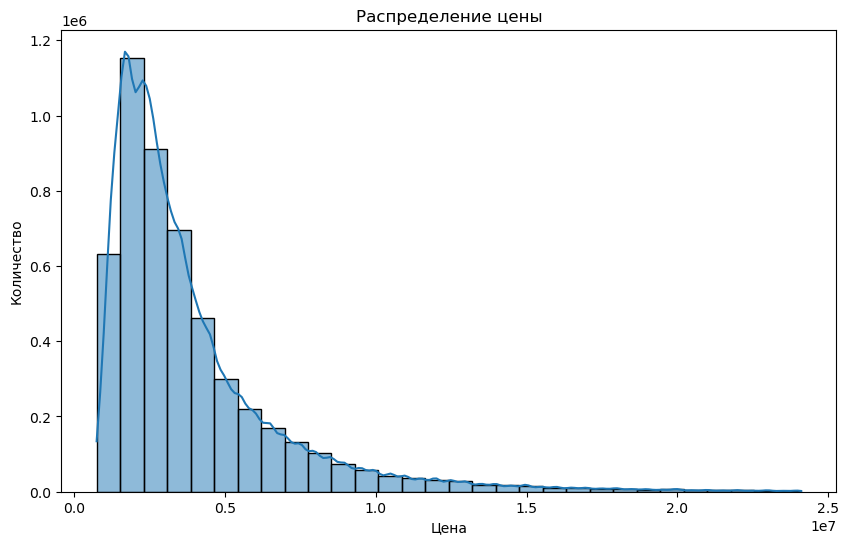

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(df.price, bins=30, kde=True)
ax.set_xlabel('Цена')
ax.set_ylabel('Количество')
ax.set_title('Распределение цены')
plt.show()

Можно заметить, распределение цены скошено вправо.

Также построим временной ряд цены в завимости от даты.

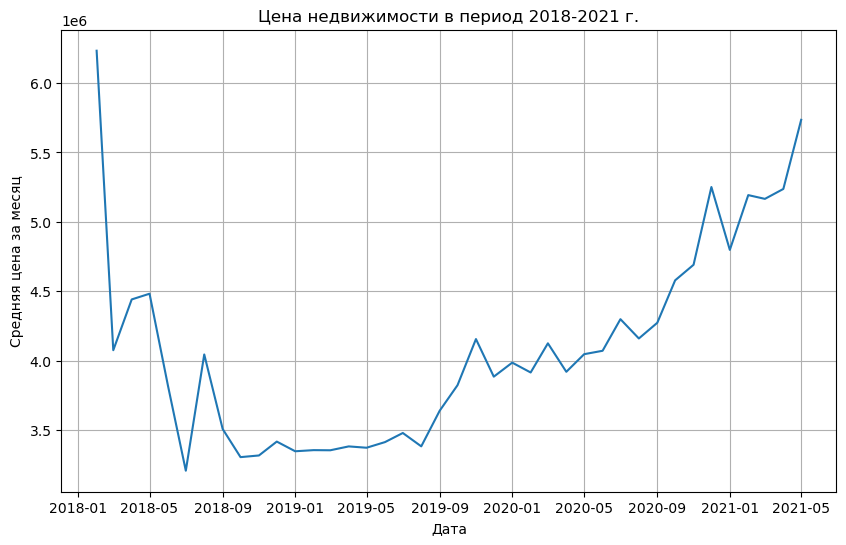

In [24]:
dates = pd.concat([df.date.dt.year, df.date.dt.month], axis=1)
dates.columns = ['year', 'month']
date_price = pd.concat([df.price, dates], axis=1)
year_month_price = date_price.groupby(['year', 'month']).agg({'price': np.mean})
date_interval = np.arange(np.datetime64("2018-02"), np.datetime64("2021-06"), np.timedelta64(1, "M"))

plt.figure(figsize=(10, 6))
plt.plot(date_interval, year_month_price.values)
plt.xlabel('Дата')
plt.ylabel('Средняя цена за месяц')
plt.title('Цена недвижимости в период 2018-2021 г.')
plt.grid(True)
plt.show()

Из данного графика можно заметить, что в период 2018 - 2019 цена вначале упала и дальше оставалась примерно на одном уровне. Далее начиная с конца 2019 года цена начала расти.

Далее построим корреляционную матрицу признаков, чтобы определить, какие признаки линейно влияют на цену.

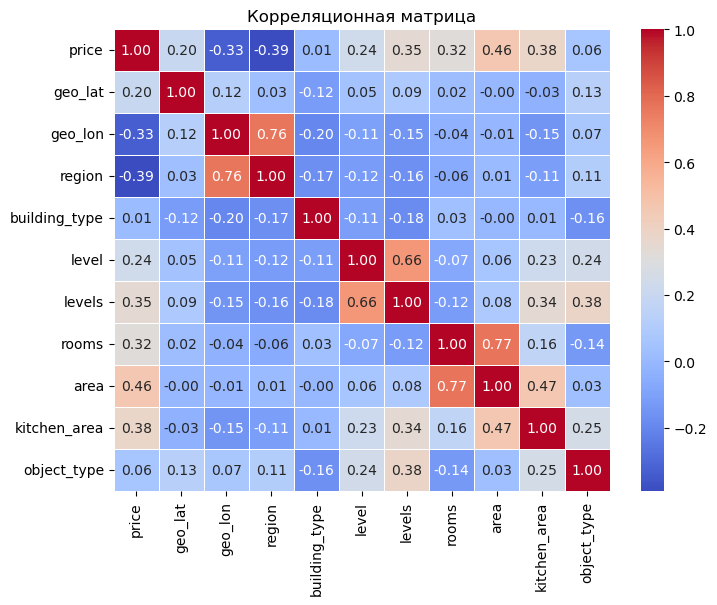

In [25]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

Из корреляционной матрицы можно заметить, что наибольшую цена имеет наибольшую корреляцию с площадью, количеством этажей и комнат.

<h2>4. Предсказание цены недвижимости </h2>

Для предсказания цены недвижимости будем использовать данные только по одному году. В данном случае возьмем 2020 г. Также сделаем отбор только необходимых признаков.

In [26]:
df_2020 = df[df.date.dt.year == 2020]
df_2020 = df_2020.drop(['date', 'time', 'geo_lat', 'geo_lon', 'region'], axis=1)
df_2020.index = np.arange(df_2020.shape[0])
df_2020.head()

,price,building_type,level,levels,rooms,area,kitchen_area,object_type,region_name
0,2100000,1,3,5,1,38.9,9.0,1,Ставропольский край
1,2150000,3,2,5,2,43.0,6.0,1,Ставропольский край
2,2500000,2,6,9,1,38.0,9.0,1,Ставропольский край
3,2100000,1,5,5,1,36.0,10.0,1,Ставропольский край
4,4900000,2,9,16,2,80.0,16.0,1,Ставропольский край


In [27]:
# Разделение данных на признаки и целевую переменную
X = df_2020.drop(['price'], axis=1)
y = df_2020['price']

In [28]:
# разделение признаков на количественные и категориальные
numeric_features = ['level', 'levels', 'area', 'kitchen_area']
categorical_features = ['region_name', 'building_type', 'object_type', 'rooms']

In [29]:
# Разделение данных на обучающую и валидационные выборки
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  random_state=42)

Вначале произведем обучение модели линейной регрессии в качестве baseline модели

In [32]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

lin_reg = LinearRegression()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lin_reg)
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae}, R²: {r2}')

MAE: 1059416.4024769221, R²: 0.7359137429628497


Средняя абсолютная ошибка составляет около 1 млн. рублей, что является слишком критичным при предсказании цены. Попробуем улучшить данные результат с помощью градиентного бустинга.

Произведем подготовку данных для CatBoostRegressor.

In [37]:
train_pool = Pool(data = X_train, label = y_train, cat_features = categorical_features)
val_pool = Pool(data = X_val, label = y_val, cat_features = categorical_features)
full_pool = Pool(data = X, label = y, cat_features = categorical_features)

In [46]:
catboost = CatBoostRegressor()

catboost.fit(train_pool,
             eval_set = val_pool,
             verbose = 200,
             plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.154728
0:	learn: 2860032.2984180	test: 2862926.2332234	best: 2862926.2332234 (0)	total: 361ms	remaining: 6m 1s
200:	learn: 1322171.4195187	test: 1329239.7073233	best: 1329239.7073233 (200)	total: 57.9s	remaining: 3m 50s
400:	learn: 1295006.1979799	test: 1305694.3613233	best: 1305694.3613233 (400)	total: 1m 57s	remaining: 2m 55s
600:	learn: 1280560.1128742	test: 1294063.1218000	best: 1294063.1218000 (600)	total: 2m 57s	remaining: 1m 57s
800:	learn: 1269165.0821550	test: 1285258.5647685	best: 1285258.5647685 (800)	total: 3m 57s	remaining: 58.9s
999:	learn: 1260289.7813637	test: 1278719.5171131	best: 1278719.5171131 (999)	total: 4m 59s	remaining: 0us

bestTest = 1278719.517
bestIteration = 999



Оценим модель с помощью кросс-валидации

In [41]:
params = {'loss_function' : 'MAE'}
mae = cv(pool = full_pool,
          params = params,
          fold_count = 3, 
          plot = False,
          verbose = False)

best_iteration = mae['test-MAE-mean'].idxmin()
best_mae = mae.loc[best_iteration, 'test-MAE-mean']
print('MAE:', best_mae)

Training on fold [0/3]

bestTest = 813960.2661
bestIteration = 999

Training on fold [1/3]

bestTest = 819604.794
bestIteration = 999

Training on fold [2/3]

bestTest = 817208.0939
bestIteration = 999

MAE: 816924.3846556538


В итоге MAE составляет около 800 тыс., что лучше линейной регрессии.
Далее произведем оценку важности признаков.

In [47]:
catboost.feature_importances_

array([ 3.64361456,  0.66309758,  9.74355367,  1.17362407, 23.49439199,
        3.97272338,  1.74158354, 55.56741121])

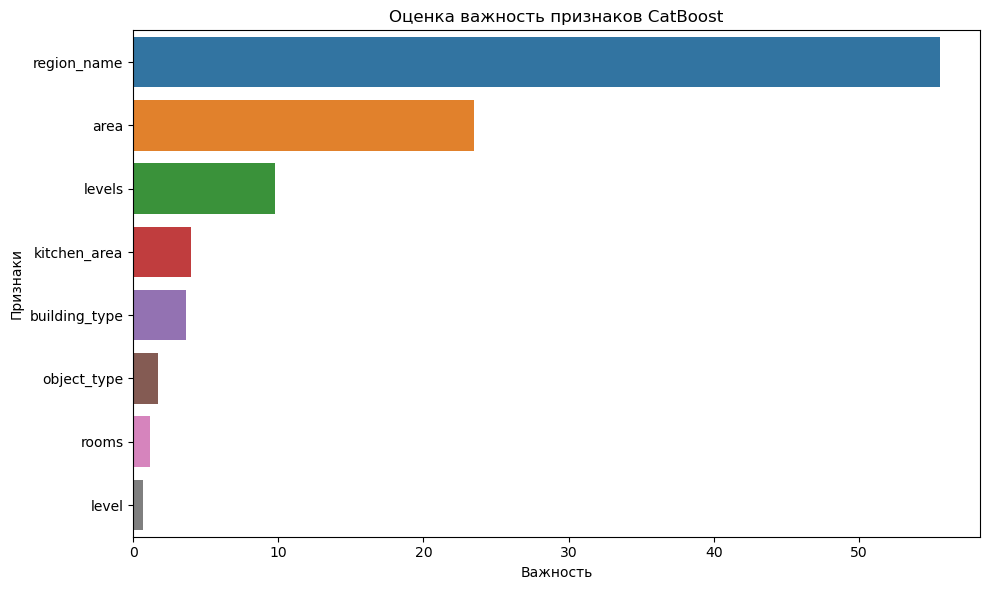

In [48]:
importance = pd.DataFrame()
importance.index = X.columns
importance['Важность'] = catboost.feature_importances_
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,6))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков CatBoost')
plt.tight_layout()
plt.show()

Как можно заметить, наибольшую важность при предсказании цены играет регион и площадь квартиры.